In [42]:
# 1) Imports and Environment Setup

from dotenv import load_dotenv  # For loading environment variables from a .env file
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import json
import time
from tqdm import tqdm
from scipy.stats import spearmanr, rankdata

import sys
sys.path.append('..')
from utils import *

# Load environment variables
load_dotenv()

# Configure to show all the columns in .head()
pd.set_option('display.max_columns', None)

print("[INFO] Environment variables loaded and libraries imported.")

[INFO] Environment variables loaded and libraries imported.


In [ ]:
# 2) Data Loading and Preparation

# Load the master dataset that has the translated version of all records
df_original = pd.read_csv('../data/new/master_translated.csv')
print(f"[INFO] Loaded master dataset with {len(df_original):,} rows.")

# Drop duplicate answer_ids to ensure each answer is only counted once
initial_count = len(df_original)
df_original.drop_duplicates(subset=['answer_id'], inplace=True)
final_count = len(df_original)
print(f"[INFO] Duplicates removed: {initial_count - final_count}")
print(f"[INFO] Dataset now has {final_count:,} rows.")

In [ ]:
df_original.info()

In [ ]:
# 3) Analyzing student answer distributions by option letter

# Count the distribution of answers (a, b, c, d, e) for each question
answer_distribution = df_original.groupby(['question_id', 'student_answer_letter']).size().unstack(fill_value=0)

# Display the first few rows of the distribution
print("[INFO] Answer distribution by question (first 5 rows):")
print(answer_distribution.head())

# Calculate the percentage distribution for each question
answer_percentage = answer_distribution.div(answer_distribution.sum(axis=1), axis=0) * 100

# Display the percentage distribution
print("\n[INFO] Answer percentage distribution by question (first 5 rows):")
print(answer_percentage.head())

# Create a new dataframe with one row per question
question_df = df_original.groupby('question_id').first().reset_index()

# Select the columns we want to keep
question_columns = [
    'question_id', 'options', 'question_title', 'correct_option', 
    'solution', 'hint', 'difficulty', 'topic_id', 'topic_name', 
    'subject_id', 'subject_name', 'axis_id', 'axis_name'
]

# Create the base dataframe with question information
questions = question_df[question_columns].copy()

# Add option columns (a, b, c, d, e)
for letter in ['a', 'b', 'c', 'd', 'e']:
    questions[f'option_{letter}'] = question_df[f'option_{letter}']

# Add correct_option_letter and student_answer_letter
questions['correct_option_letter'] = question_df['correct_option_letter']
questions['student_answer_letter'] = question_df['student_answer_letter']

# Add count columns for each answer option
for letter in ['a', 'b', 'c', 'd', 'e']:
    # Merge the counts from answer_distribution
    letter_counts = answer_distribution[letter].reset_index().rename(columns={letter: f'count_{letter}'})
    questions = pd.merge(questions, letter_counts, on='question_id', how='left')
    # Fill NaN values with 0 for questions that didn't receive that answer
    questions[f'count_{letter}'] = questions[f'count_{letter}'].fillna(0).astype(int)

# Visualize the distribution for a few sample questions
plt.figure(figsize=(12, 8))
sample_questions = answer_percentage.head(5).index

for i, question in enumerate(sample_questions, 1):
    plt.subplot(2, 3, i)
    answer_percentage.loc[question].plot(kind='bar', color=['#F1F5F9', '#CBD5E1', '#94A3B8', '#64748B', '#334155'])
    plt.title(f"Question {i}", fontsize=10)
    plt.ylabel('Percentage (%)')
    plt.xlabel('Answer Option')
    plt.xticks(rotation=0)
    plt.ylim(0, 100)

plt.tight_layout()
plt.suptitle('Distribution of Student Answers by Option', y=1.02)
plt.show()

# Summary statistics
print("\n[INFO] Summary of answer distributions:")
print(f"Average percentage choosing option a: {answer_percentage.get('a', 0).mean():.2f}%")
print(f"Average percentage choosing option b: {answer_percentage.get('b', 0).mean():.2f}%")
print(f"Average percentage choosing option c: {answer_percentage.get('c', 0).mean():.2f}%")
print(f"Average percentage choosing option d: {answer_percentage.get('d', 0).mean():.2f}%")
print(f"Average percentage choosing option e: {answer_percentage.get('e', 0).mean():.2f}%")

# Display the first few rows of the new questions dataframe
print("\n[INFO] New questions dataframe (first 5 rows):")
print(questions.head())


In [ ]:
# Display all columns of the dataframe
pd.set_option('display.max_columns', None)
pd.set_option('display.width', 1000)

len(questions)

In [15]:
questions.to_csv('questions_with_counts.csv', index=False)

In [ ]:
questions = pd.read_csv('questions_with_counts.csv')

# Check if we already have progress saved
progress_file = 'questions_with_distractors_progress.csv'
start_idx = 0

if os.path.exists(progress_file):
    print(f"[INFO] Found existing progress file. Loading from {progress_file}")
    questions = pd.read_csv(progress_file)
    # Find the last processed row (non-null rank_1_letter)
    processed_rows = questions[questions['rank_1_letter'].notna()]
    if not processed_rows.empty:
        start_idx = processed_rows.index.max() + 1
        print(f"[INFO] Resuming from index {start_idx} ({len(processed_rows)} questions already processed)")
        print(f"[INFO] That's {len(processed_rows)/len(questions)*100:.2f}% of total questions")

# Create new columns for distractor rankings if they don't exist
if 'rank_1_letter' not in questions.columns:
    questions['rank_1_letter'] = None
if 'rank_2_letter' not in questions.columns:
    questions['rank_2_letter'] = None
if 'rank_3_letter' not in questions.columns:
    questions['rank_3_letter'] = None
if 'rank_4_letter' not in questions.columns:
    questions['rank_4_letter'] = None
if 'reasoning' not in questions.columns:
    questions['reasoning'] = None

print(f"[INFO] Total questions to process: {len(questions)}")
print(f"[INFO] Questions remaining: {len(questions) - start_idx}")

# Function to create prompt for R1
def create_distractor_prompt(row):  
    # Create the prompt
    prompt = f"""
Take a look at the following question and options:

Axis: {row['axis_name']}
Subject: {row['subject_name']}
Topic: {row['topic_name']}
Question: {row['question_title']}

Options:
a) {row['option_a']}
b) {row['option_b']}
c) {row['option_c']}
d) {row['option_d']}
e) {row['option_e']}

Correct option: {row['correct_option_letter']}

For the options that are NOT the correct option, rank them in terms of attractiveness as a distractor.
A distractor is an incorrect option that students are likely to choose if they don't know the correct answer.

Consider these factors when determining attractiveness:
1. Plausibility - how reasonable or correct the option appears at first glance
2. Similarity - how closely it resembles the correct answer in wording or concept
3. Common misconceptions - whether it captures mistakes students typically make
4. Partial understanding - whether it represents incomplete knowledge of the subject

Rank from 1 (most attractive as a distractor) to 4 (least attractive as a distractor).
If two options seem equally attractive, prioritize the one that appears earlier in the alphabet.

Please provide your response in JSON format like this:
{{
  "rank_1_letter": "letter of most attractive distractor",
  "rank_2_letter": "letter of second most attractive distractor",
  "rank_3_letter": "letter of third most attractive distractor",
  "rank_4_letter": "letter of least attractive distractor"
}}

All letters should be lowercase.
First reason through this task in <thinking></thinking> tags.
Then, after the </thinking> tag, output the JSON, nothing else. No backticks, no code blocks, no markdown. Just the JSON.
"""
    return prompt

# Process each question with R1
print("[INFO] Processing questions with R1 model...")
start_time = time.time()
successful_count = 0
error_count = 0

for idx, row in tqdm(questions.iloc[start_idx:].iterrows(), total=len(questions) - start_idx):
    try:
        # Create prompt
        prompt = create_distractor_prompt(row)
        
        print(f"\n[INFO] Processing question {idx} (ID: {row.get('question_id', 'N/A')})")
        print(f"[INFO] Question: {row['question_title'][:50]}...")
        print(f"[INFO] Correct option: {row['correct_option_letter']}")
        
        # Get response from R1
        response, reasoning = get_flash_response(prompt)
        
        # Parse the JSON response
        try:
            # Try to find JSON in the response
            if response is not None:
                json_start = response.find('{')
                json_end = response.rfind('}') + 1
                if json_start >= 0 and json_end > json_start:
                    json_str = response[json_start:json_end]
                    rankings = json.loads(json_str)
                    
                    # Update the dataframe
                    questions.at[idx, 'rank_1_letter'] = rankings.get('rank_1_letter')
                    questions.at[idx, 'rank_2_letter'] = rankings.get('rank_2_letter')
                    questions.at[idx, 'rank_3_letter'] = rankings.get('rank_3_letter')
                    questions.at[idx, 'rank_4_letter'] = rankings.get('rank_4_letter')
                    questions.at[idx, 'reasoning'] = reasoning
                    
                    print(f"[SUCCESS] Rankings: 1:{rankings.get('rank_1_letter')}, 2:{rankings.get('rank_2_letter')}, 3:{rankings.get('rank_3_letter')}, 4:{rankings.get('rank_4_letter')}")
                    successful_count += 1
                else:
                    print(f"[WARNING] Could not find JSON in response for question {idx}")
                    print(f"[DEBUG] Response: {response[:100]}...")
                    error_count += 1
            else:
                print(f"[WARNING] Response is None for question {idx}")
                error_count += 1
        except json.JSONDecodeError:
            print(f"[ERROR] Failed to parse JSON for question {idx}")
            print(f"[DEBUG] Response: {response[:100]}...")
            error_count += 1
        
        # Save progress every 10 rows
        if (idx - start_idx + 1) % 10 == 0:
            elapsed_time = time.time() - start_time
            questions_processed = idx - start_idx + 1
            avg_time_per_question = elapsed_time / questions_processed
            remaining_questions = len(questions) - idx - 1
            estimated_time_remaining = remaining_questions * avg_time_per_question
            
            print(f"\n[INFO] === PROGRESS UPDATE ===")
            print(f"[INFO] Saving progress after processing {questions_processed} questions...")
            print(f"[INFO] Success rate: {successful_count/questions_processed*100:.2f}% ({successful_count}/{questions_processed})")
            print(f"[INFO] Error rate: {error_count/questions_processed*100:.2f}% ({error_count}/{questions_processed})")
            print(f"[INFO] Average time per question: {avg_time_per_question:.2f} seconds")
            print(f"[INFO] Estimated time remaining: {estimated_time_remaining/60:.2f} minutes ({estimated_time_remaining/3600:.2f} hours)")
            print(f"[INFO] Overall progress: {(idx+1)/len(questions)*100:.2f}% ({idx+1}/{len(questions)})")
            
            questions.to_csv(progress_file, index=False)
            print(f"[INFO] Progress saved to {progress_file}")
        
        # Add a small delay to avoid rate limiting
        # time.sleep(0.5)
        
    except Exception as e:
        print(f"[ERROR] Failed to process question {idx}: {str(e)}")
        print(f"[DEBUG] Exception type: {type(e).__name__}")
        error_count += 1
        # Save progress when an exception occurs
        questions.to_csv(progress_file, index=False)
        print(f"[INFO] Progress saved to {progress_file} after error")

# Calculate final statistics
total_time = time.time() - start_time
total_processed = len(questions) - start_idx
avg_time_per_question = total_time / total_processed if total_processed > 0 else 0

# Save the final results
questions.to_csv('questions_with_distractors.csv', index=False)
questions.to_csv(progress_file, index=False)  # Also update the progress file

print("\n[INFO] === FINAL SUMMARY ===")
print(f"[INFO] Completed distractor analysis")
print(f"[INFO] Total questions processed: {total_processed}")
print(f"[INFO] Successful: {successful_count} ({successful_count/total_processed*100:.2f}%)")
print(f"[INFO] Errors: {error_count} ({error_count/total_processed*100:.2f}%)")
print(f"[INFO] Total time: {total_time/60:.2f} minutes ({total_time/3600:.2f} hours)")
print(f"[INFO] Average time per question: {avg_time_per_question:.2f} seconds")
print(f"[INFO] Sample of results (first 5 rows):")
print(questions[['question_title', 'correct_option', 'rank_1_letter', 'rank_2_letter', 'rank_3_letter', 'rank_4_letter']].head())


In [60]:
questions = pd.read_csv('questions_with_distractors.csv')

# Calculate the total count of student answers for each question
questions['total_counts'] = questions['count_a'] + questions['count_b'] + questions['count_c'] + questions['count_d'] + questions['count_e']

In [61]:
# Print the number of questions before filtering
print(f"Number of questions before filtering: {len(questions)}")

# Filter questions to keep only those with at least 10 student answers
filtered_questions = questions[questions['total_counts'] >= 10]

# Print the number of questions after filtering
print(f"Number of questions after filtering: {len(filtered_questions)}")
print(f"Removed {len(questions) - len(filtered_questions)} questions with fewer than 10 student answers")

# Update the questions dataframe with the filtered version
questions = filtered_questions

Number of questions before filtering: 9769
Number of questions after filtering: 4696
Removed 5073 questions with fewer than 10 student answers


In [65]:
# Filter out questions that have images
print(f"Number of questions before removing those with images: {len(questions)}")

questions_with_images_ids = pd.read_csv('questions_with_images.csv')

# Convert question_id columns to the same data type to ensure proper comparison
questions['question_id'] = questions['question_id'].astype(int)
questions_with_images_ids['question_id'] = questions_with_images_ids['question_id'].astype(int)

# Filter out questions that are in the questions_with_images_ids dataframe
questions = questions[~questions['question_id'].isin(questions_with_images_ids['question_id'])]

# Print the number of questions after filtering
print(f"Number of questions after removing those with images: {len(questions)}")
print(f"Removed {len(filtered_questions) - len(questions)} questions with images")


Number of questions before removing those with images: 4696
Number of questions after removing those with images: 3914
Removed 782 questions with images


In [66]:
questions = questions.rename(columns={
    'rank_1_letter': 'llm_rank_1_letter',
    'rank_2_letter': 'llm_rank_2_letter',
    'rank_3_letter': 'llm_rank_3_letter',
    'rank_4_letter': 'llm_rank_4_letter'
})

In [67]:
questions.info()

<class 'pandas.core.frame.DataFrame'>
Index: 3914 entries, 0 to 9768
Data columns (total 31 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   question_id            3914 non-null   int64  
 1   options                3914 non-null   object 
 2   question_title         3914 non-null   object 
 3   correct_option         3914 non-null   object 
 4   solution               3914 non-null   object 
 5   hint                   3912 non-null   object 
 6   difficulty             3914 non-null   float64
 7   topic_id               3914 non-null   int64  
 8   topic_name             3914 non-null   object 
 9   subject_id             3914 non-null   int64  
 10  subject_name           3914 non-null   object 
 11  axis_id                3914 non-null   int64  
 12  axis_name              3914 non-null   object 
 13  option_a               3914 non-null   object 
 14  option_b               3914 non-null   object 
 15  option_c 

In [68]:
# Keep your original rank_distractors function
def rank_distractors(row):
    # Get the correct option letter
    correct_letter = row['correct_option_letter']
    
    # Create a dictionary of distractor letters and their counts
    distractors = {}
    for letter in ['a', 'b', 'c', 'd', 'e']:
        if letter != correct_letter:
            distractors[letter] = row[f'count_{letter}']
    
    # Sort distractors by count in descending order
    sorted_distractors = sorted(distractors.items(), key=lambda x: x[1], reverse=True)
    
    # Create the ranking
    ranks = {}
    for i, (letter, _) in enumerate(sorted_distractors, 1):
        ranks[f'actual_rank_{i}_letter'] = letter
    
    return pd.Series(ranks)

# Apply the function to each row and join the results to the original dataframe
rank_columns = questions.apply(rank_distractors, axis=1)
questions = pd.concat([questions, rank_columns], axis=1)

# Print a sample to verify the results
print("\nSample of questions with actual distractor rankings:")
sample_cols = ['question_title', 'correct_option_letter', 
               'actual_rank_1_letter', 'actual_rank_2_letter', 
               'actual_rank_3_letter', 'actual_rank_4_letter']

questions.head()


Sample of questions with actual distractor rankings:


,question_id,options,question_title,correct_option,solution,hint,difficulty,topic_id,topic_name,subject_id,subject_name,axis_id,axis_name,option_a,option_b,option_c,option_d,option_e,correct_option_letter,student_answer_letter,count_a,count_b,count_c,count_d,count_e,llm_rank_1_letter,llm_rank_2_letter,llm_rank_3_letter,llm_rank_4_letter,reasoning,total_counts,actual_rank_1_letter,actual_rank_2_letter,actual_rank_3_letter,actual_rank_4_letter
0,28193,"""---\n- \""`p(x)`\""\n- \""`n(x)`\""\n- \""`h(x)`\""...",Which of the following functions corresponds t...,`m(x)`,Paso 1<br /><br />Podemos identificar que la f...,Amplificar por -1 a la variable independiente ...,-1.005209,441,Translation of the graph of exponential function,120,"Exponential function, logarithmic, root and power",24,Algebra,`p(x)`,`n(x)`,`h(x)`,`m(x)`,`g(x)`,d,d,0,2,3,5,0,c,b,a,e,The question asks which function corresponds t...,10,c,b,a,e
2,21906,"""---\n- Figura `a)`\n- Figura `c)`\n- Figura `...",The homothetic figure of `A` with respect to t...,Figura `b)`,Paso 1: <br><br>Lo primero es identificar que ...,Recordar que si la razón de homotecia es `k&gt...,-2.015912,487,Homothety of plane figures,199,Homothety and Thales' Theorem,25,Geometry,Figure `a)`,Figure `c)`,Figure `d)`,Figure `e)`,Figure `b)`,e,c,2,9,12,5,31,c,a,d,b,The question asks about homothety with respect...,59,c,b,d,a
3,15904,"[""`2,31`"", ""`2,319`"", ""`2,32`"", ""`2,30`"", ""`2,...",<div>Which of the following alternatives repre...,"`2,31`","<div>Paso 1. Tomaremos el número, y lo escribi...",<div>Al aproximar por defecto en una determina...,-1.013037,414,Rational approximation,113,Rational numbers,23,Numbers,"`2,31`","`2,319`","`2,32`","`2,30`","`2,21`",a,c,6,0,4,3,0,c,b,d,e,The question asks for the approximation to the...,13,c,d,b,e
5,16141,"""---\n- '0,6 - 0,55 - 0,5 - 0,48 '\n- 0,48 - 0...",<div>What is the corresponding order from grea...,"0,6 - 0,55 - 0,5 - 0,48",<div>Paso 1. Tomaremos todos los números y los...,<div>Te recomendamos pasar todos a centésimas ...,-1.228167,415,Order of rational numbers,113,Rational numbers,23,Numbers,0.6 - 0.55 - 0.5 - 0.48,0.48 - 0.5 - 0.55 - 0.6,0.6 - 0.5 - 0.55 - 0.48,0.55 - 0.6 - 0.5 - 0.48,0.48 - 0.6 - 0,a,a,23,2,3,0,0,b,c,d,e,Let's analyze each incorrect option to determi...,28,c,b,d,e
6,16158,"""---\n- \""`2\\\\sqrt5 &gt; 4\\\\sqrt3 &gt;5\\\...",What is the decreasing order of the roots `4\s...,`5\sqrt2 &gt; 4\sqrt3 &gt; 3\sqrt4 &gt; 2\sqrt5`,"Paso 1. Primero, expresaremos todos como raíce...","1. Orden decreciente, es de mayor a menor.<br>...",-1.141942,420,Order of real numbers,114,Real numbers,23,Numbers,`2\sqrt5 > 4\sqrt3 > 5\sqrt2 > 3\sqrt4`,`2\sqrt5 > 3\sqrt4 > 4\sqrt3 > 5\sqrt2`,`5\sqrt2 > 3\sqrt4 > 4\sqrt3 > 2\sqrt5`,`5\sqrt2 > 4\sqrt3 > 3\sqrt4 > 2\sqrt5`,`2\sqrt5,d,d,0,3,0,15,5,c,a,b,e,Let's analyze the given question and the optio...,23,e,b,a,c


/var/folders/_q/rqr7_q191gx4ps32w9wtkmgw0000gn/T/ipykernel_3084/3363948854.py:41: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlation, _ = spearmanr(llm_ranks, actual_ranks)



Average Spearman correlation between LLM and actual distractor rankings: 0.1122
Top-1 accuracy (correctly identifying the most chosen distractor): 34.34%
Bottom-1 accuracy (correctly identifying the least chosen distractor): 34.13%


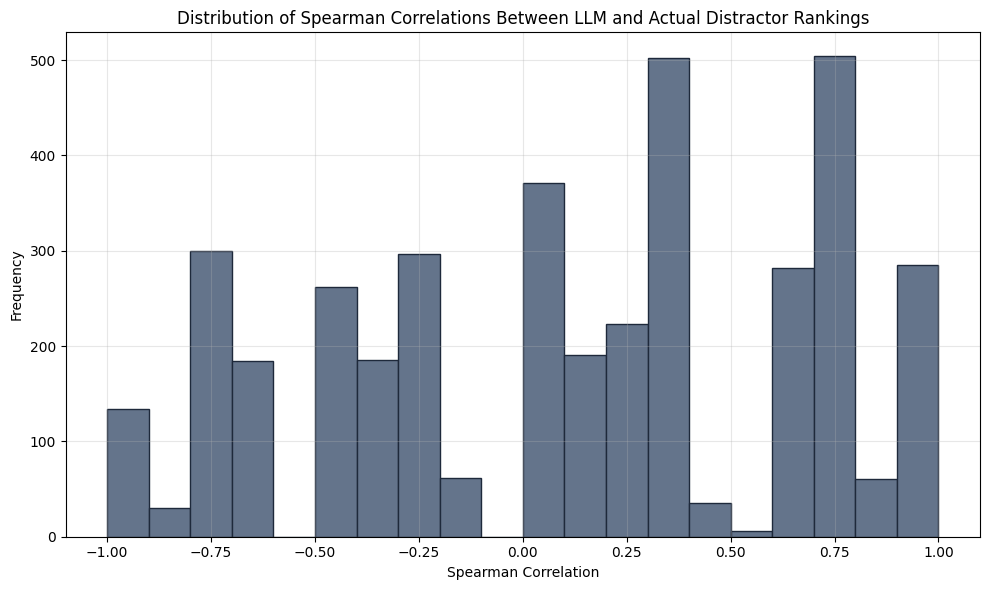

Percentage of questions with positive correlation: 53.37%
Percentage of questions with strong correlation (> 0.5): 28.92%


In [69]:
# Modified function to calculate Spearman correlation that properly handles ties
def calculate_spearman_correlation(row):
    # Get the correct option letter
    correct_letter = row['correct_option_letter']
    
    # Create lists to store letter, LLM rank, and actual count for each distractor
    letters = []
    llm_ranks = []
    actual_counts = []
    
    # Collect data for each distractor
    for letter in ['a', 'b', 'c', 'd', 'e']:
        if letter != correct_letter:
            # Check if we have an LLM rank for this letter
            llm_rank = None
            for i in range(1, 5):
                if row.get(f'llm_rank_{i}_letter') == letter:
                    llm_rank = i
                    break
            
            # If we have an LLM rank, add this distractor to our lists
            if llm_rank is not None:
                letters.append(letter)
                llm_ranks.append(llm_rank)
                actual_counts.append(row.get(f'count_{letter}', 0))
    
    # If we don't have enough data, return 0
    if len(letters) < 2:
        return pd.Series({
            'spearman_correlation': 0.0,
            'top1_correct': False,
            'bottom1_correct': False
        })
    
    # Calculate ranks from actual counts (higher count = lower rank)
    # We use scipy's rankdata function which correctly handles ties
    # by assigning the average rank to tied values
    actual_ranks = rankdata([-count for count in actual_counts])  # Negate to rank in descending order
    
    # Calculate Spearman correlation between LLM ranks and actual ranks
    correlation, _ = spearmanr(llm_ranks, actual_ranks)
    correlation_value = correlation if not np.isnan(correlation) else 0.0
    
    # Check if top1 prediction is correct
    llm_top1_letter = row.get('llm_rank_1_letter')
    actual_top1_letter = row.get('actual_rank_1_letter')
    top1_correct = llm_top1_letter == actual_top1_letter if llm_top1_letter and actual_top1_letter else False
    
    # Check if bottom1 prediction is correct
    llm_bottom1_letter = row.get('llm_rank_4_letter')
    actual_bottom1_letter = row.get('actual_rank_4_letter')
    bottom1_correct = llm_bottom1_letter == actual_bottom1_letter if llm_bottom1_letter and actual_bottom1_letter else False
    
    return pd.Series({
        'spearman_correlation': correlation_value,
        'top1_correct': top1_correct,
        'bottom1_correct': bottom1_correct
    })

# Apply the function to each row
metrics = questions.apply(calculate_spearman_correlation, axis=1)
questions = pd.concat([questions, metrics], axis=1)

# Calculate the average Spearman correlation across all questions
avg_correlation = questions['spearman_correlation'].mean()
print(f"\nAverage Spearman correlation between LLM and actual distractor rankings: {avg_correlation:.4f}")

# Calculate top1 and bottom1 accuracy
top1_accuracy = questions['top1_correct'].mean() * 100
bottom1_accuracy = questions['bottom1_correct'].mean() * 100
print(f"Top-1 accuracy (correctly identifying the most chosen distractor): {top1_accuracy:.2f}%")
print(f"Bottom-1 accuracy (correctly identifying the least chosen distractor): {bottom1_accuracy:.2f}%")

# Create a histogram of the Spearman correlations
plt.figure(figsize=(10, 6))
plt.hist(questions['spearman_correlation'], bins=20, color='#64748B', edgecolor='#1E293B')
plt.title('Distribution of Spearman Correlations Between LLM and Actual Distractor Rankings')
plt.xlabel('Spearman Correlation')
plt.ylabel('Frequency')
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

# Calculate the percentage of questions with positive correlation
positive_corr_pct = (questions['spearman_correlation'] > 0).mean() * 100
print(f"Percentage of questions with positive correlation: {positive_corr_pct:.2f}%")

# Calculate the percentage of questions with strong correlation (> 0.5)
strong_corr_pct = (questions['spearman_correlation'] > 0.5).mean() * 100
print(f"Percentage of questions with strong correlation (> 0.5): {strong_corr_pct:.2f}%")

In [70]:
# Compute the average of the column 'spearman_correlation'
average_correlation = questions['spearman_correlation'].mean()
print(f"Average Spearman correlation: {average_correlation:.4f}")

# Compute the median of the column 'spearman_correlation'
median_correlation = questions['spearman_correlation'].median()
print(f"Median Spearman correlation: {median_correlation:.4f}")

# Calculate percentages of correct top1 and bottom1 predictions
top1_correct_pct = questions['top1_correct'].mean() * 100
bottom1_correct_pct = questions['bottom1_correct'].mean() * 100
print(f"Percentage of questions where top1 prediction is correct: {top1_correct_pct:.2f}%")
print(f"Percentage of questions where bottom1 prediction is correct: {bottom1_correct_pct:.2f}%")

Average Spearman correlation: 0.1122
Median Spearman correlation: 0.2000
Percentage of questions where top1 prediction is correct: 34.34%
Percentage of questions where bottom1 prediction is correct: 34.13%


In [71]:
# Save to csv
questions.to_csv('questions_with_spearman_correlation.csv', index=False)